# Прогноз стоимости автомобилей

## Поставновка задачи

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. Одной из функций приложения должна стать возможность быстрой оценки рыночной стоимости автомобиля. 

В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания (для оценки качества моделей применяем метрику RMSE, threshold = `2500`);
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек, установка констант

In [1]:
import pandas as pd
import numpy as np
import time

import pgeocode
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings

Настройки отображения, установка констант

In [2]:
# устанавливаем формат отображения float в 3 знака в дробной части
pd.set_option('display.float_format', '{:.3f}'.format)

# устанавливаем макс. значение для отображения столбцов
pd.options.display.max_columns = 45

# отключаем предупреждения
warnings.filterwarnings("ignore")

RND_ST = 7777
COUNTRY = 'DE'
CHNK_SIZE = 1000
TRN_TST_RATIO = .25
N_FOLDS = 5

### Предобработка

#### Чтение данных

In [3]:
df = pd.read_csv('datasets/autos.csv')

In [4]:
df.shape

(354369, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe(include='int')

Price  RegistrationYear      Power  Kilometer  RegistrationMonth  \
count 354369.000        354369.000 354369.000 354369.000         354369.000   
mean    4416.657          2004.234    110.094 128211.173              5.715   
std     4514.159            90.228    189.850  37905.342              3.726   
min        0.000          1000.000      0.000   5000.000              0.000   
25%     1050.000          1999.000     69.000 125000.000              3.000   
50%     2700.000          2003.000    105.000 150000.000              6.000   
75%     6400.000          2008.000    143.000 150000.000              9.000   
max    20000.000          9999.000  20000.000 150000.000             12.000   

       NumberOfPictures  PostalCode  
count        354369.000  354369.000  
mean              0.000   50508.689  
std               0.000   25783.096  
min               0.000    1067.000  
25%               0.000   30165.000  
50%               0.000   49413.000  
75%               0.000   71083.000  
max               0.000   99998.000

In [7]:
df.describe(include='object')

DateCrawled VehicleType Gearbox   Model FuelType       Brand  \
count                354369      316879  334536  334664   321474      354369   
unique               271174           8       2     250        7          40   
top     2016-03-24 14:49:47       sedan  manual    golf   petrol  volkswagen   
freq                      7       91457  268251   29232   216352       77013   

       NotRepaired          DateCreated             LastSeen  
count       283215               354369               354369  
unique           2                  109               179150  
top             no  2016-04-03 00:00:00  2016-04-06 13:45:54  
freq        247161                13719                   17

Столбец `NumberOfPictures` не содержит информации - все значения равны нулю. Этот столбец удалим.

Столбцы `DateCrawled`, `DateCreated` и `LastSeen` для целей прогноза стоимости не требуются. Информация в них скорее относится к ативности пользователя, нежели является фактором прогноза цены автомобиля.

Удаляем столбцы `NumberOfPictures`, `DateCrawled`, `DateCreated` и `LastSeen`

In [8]:
df = df.drop(['NumberOfPictures',
              'DateCrawled',
              'DateCreated',
              'LastSeen'],
             axis=1)

Приводим все строковые данные к нижнему регистру

In [9]:
for item in df.describe(include='object').columns:
    df[item] = df[item].str.lower()

Переименование столбцов в соответствии с принятыми правилами наименования

In [10]:
col_names = {'Price':'price',
             'VehicleType':'type',
             'RegistrationYear':'reg_year',
             'Gearbox':'gearbox',
             'Power':'power',
             'Model':'model',
             'Kilometer':'km',
             'RegistrationMonth':'reg_month',
             'FuelType':'fuel',
             'Brand':'brand',
             'NotRepaired':'not_repaired',
             'PostalCode':'postal_code'
            }

for item in col_names:
    df.rename(columns={item : col_names.get(item)}, inplace=True)

Удаляем дубликаты, смотрим на число пропусков

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
# подсчет NaN (кол-во и % от всех значений) по столбцам

pd.DataFrame(
    data=( {
    'NaN_qty': [df[column].isna().sum() for column in df.columns],
    'NaN_prcnt' : [( df[column].isna().sum()/len(df)*100 ).astype('int8') for column in df.columns],
    'Type' : df.dtypes
    } ),
    index=df.columns).query('NaN_qty != 0').sort_values(by='NaN_qty', ascending=False)

NaN_qty  NaN_prcnt    Type
not_repaired    68063         20  object
type            36140         10  object
fuel            31902          9  object
model           19023          5  object
gearbox         19015          5  object

Смотрим на уникальные значения в столбцах

In [13]:
for col in df.columns:
    display(df[col].value_counts().to_frame())

price
0      10013
500     5471
1500    5112
1000    4409
1200    4355
...      ...
9001       1
2278       1
615        1
477        1
10985      1

[3731 rows x 1 columns]

type
sedan        85642
small        74858
wagon        60891
bus          27054
convertible  18908
coupe        15262
suv          11097
other         3184

reg_year
2000     23102
1999     21449
2005     20753
2001     18892
2006     18551
...        ...
6500         1
2290         1
1001         1
9450         1
3500         1

[151 rows x 1 columns]

gearbox
manual   252216
auto      61805

power
0     38664
75    22543
60    14853
150   13541
101   12495
...     ...
2789      1
519       1
2461      1
6006      1
1241      1

[712 rows x 1 columns]

model
golf                27402
other               23352
3er                 18528
polo                12308
corsa               11773
...                   ...
serie_2                 8
rangerover              4
serie_3                 4
serie_1                 2
range_rover_evoque      1

[250 rows x 1 columns]

km
150000  224412
125000   34175
100000   13927
90000    10729
80000     9359
70000     8114
60000     6847
5000      6163
50000     5808
40000     4524
30000     4079
20000     3737
10000     1162

reg_month
0       35789
3       32213
6       29579
4       27674
5       27372
7       25620
10      24301
12      22674
11      22601
9       22242
1       21822
8       21223
2       19926

fuel
petrol    203192
gasoline   91940
lpg         4954
cng          531
hybrid       228
other        200
electric      89

brand
volkswagen      72168
opel            37469
bmw             34523
mercedes_benz   30180
audi            27600
ford            23696
renault         16913
peugeot         10281
fiat             9081
seat             6485
mazda            5304
skoda            5148
smart            4975
citroen          4889
nissan           4655
toyota           4377
hyundai          3377
sonstige_autos   3240
volvo            2989
mini             2982
mitsubishi       2881
honda            2696
kia              2298
suzuki           2201
alfa_romeo       2200
chevrolet        1664
chrysler         1373
dacia             844
daihatsu          765
subaru            732
porsche           713
jeep              646
trabant           569
daewoo            515
land_rover        515
saab              491
jaguar            480
rover             459
lancia            447
lada              215

not_repaired
no         230326
yes         34647

postal_code
65428          561
32257          305
66333          304
44145          297
78224          284
...            ...
1778             1
17329            1
97528            1
91744            1
31096            1

[8143 rows x 1 columns]

- `price` есть много нулевых значений. Эти записи не нужны, нулевой целевой признак - это явная ошибка в данных. 
- `vehicle_type` аномальных значений нет, годится в качестве категориального столбца.
- `reg_year` есть аномальные значения (например, 1200 или 4100). Надо смотреть подробнее.
- `gearbox` отличный категориальный столбец.
- `power` есть аномальные значения (например, 0 или 3454). Надо смотреть подробнее.
- `model` присутствуют 250 уникальных значения. Надо смотреть подробнее на предмет ошибок, дублирования и т.п.
- `km` целесоообразно разделить все значения на 1000, чтоб оперировать данными в меньшем масштабе
- `reg_month` значение 0 выглядит странным...Кроме того, в реальности на цену авто влияет скорее год регистрации (в нашем примере год регистрации - единственное, что косвенно указывает на возраст авто). Удалим столбец.
- `fuel` аномальных значений нет, годится в качестве категориального столбца.
- `brand` аномальных значений нет, годится в качестве категориального столбца.
- `not_repaired` отличный категориальный столбец.
- `postal_codes` значений слишком много. Нужно попытаться перевести информацию из формата кодов в формат административных единиц.

In [14]:
if 'reg_month' in df.columns:
    df = df.drop('reg_month', axis=1)

if min(df['km']) > 1000:
    df['km'] = df['km']//1000 # целочисленное деление, чтоб не получить float

#### Столбец `price`

Удалим нулевые значения

In [15]:
before = df.shape[0]
df = df.drop(df[df['price']==0].index, axis=0)
after = df.shape[0]
print(
    f'Удалено строк: {before - after} или ~ {round((before - after)*100/before)}% от первоначального размера'
)

Удалено строк: 10013 или ~ 3% от первоначального размера


Посмотрим на распределение в области малых значений цены (*до 100 включтительно*)

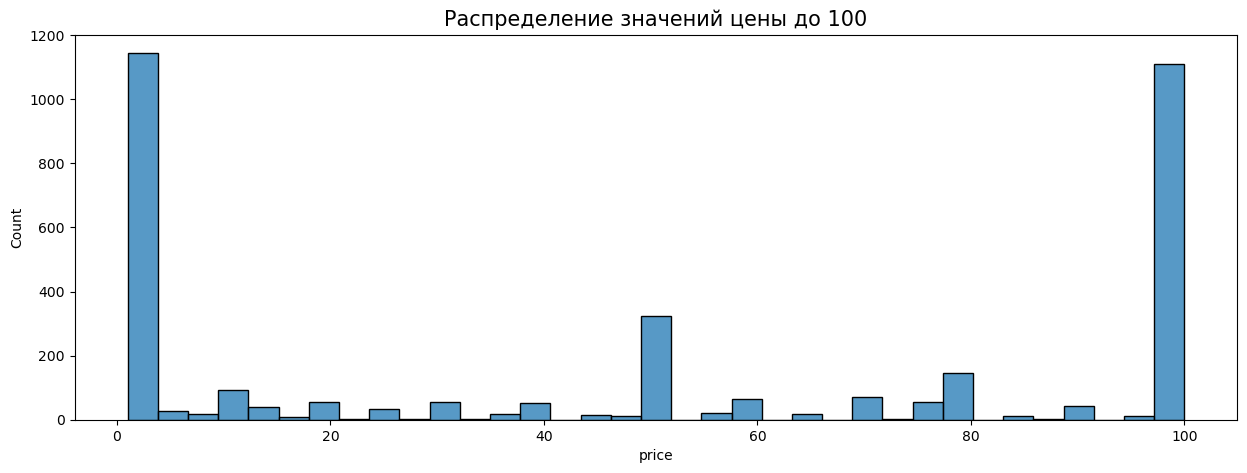

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df.query('0 < price <= 100'), x='price', bins=35, ax=ax)
ax.set_title('Распределение значений цены до 100', size=15)
plt.show()

In [17]:
print(
    'Всего значений менее 100: ',
    df[df['price'] < 100]['price'].value_counts().sum(),
    ' или ',
    round((df[df['price'] < 100]['price'].value_counts().sum()/len(df))*100, 2),
    '% от всех данных'
)
print(
    'Из них значений равных 1: ',
    df[df['price'] == 1]['price'].value_counts().sum(),
    ' или ',
    round(
        (
            df[df['price'] == 1]['price'].value_counts().sum()
            /df[df['price'] < 100]['price'].value_counts().sum()
        )
        * 100
    ),
    '%'
)
print(
    'Из них значений равных 50: ',
    df[df['price'] == 50]['price'].value_counts().sum(),
    ' или ',
    round(
        (
            df[df['price'] == 50]['price'].value_counts().sum()
            /df[df['price'] < 100]['price'].value_counts().sum()
        )
        * 100
    ),
    '%'
)
print(
    'Из них значений равных 80: ',
    df[df['price'] == 80]['price'].value_counts().sum(),
    ' или ',
    round(
        (
            df[df['price'] == 80]['price'].value_counts().sum()
            /df[df['price'] < 100]['price'].value_counts().sum()
        )
        * 100
    ),
    '%'
)

Всего значений менее 100:  2452  или  0.76 % от всех данных
Из них значений равных 1:  1125  или  46 %
Из них значений равных 50:  323  или  13 %
Из них значений равных 80:  142  или  6 %


Значений менее 100 насчитывается 2452 или примерно 0.76% от всех данных. Причем подавляющее кол-во (46%) это значения раные `1`.
Проведем "нижнюю границу" по цене по значению 100. Все, что менее - отбрасываем.

In [18]:
before = df.shape[0]
df = df.drop(df[df['price']<100].index, axis=0)
after = df.shape[0]
print(
    f'Удалено строк: {before - after} или ~ {round((before - after)*100/before, 2)}% от первоначального размера'
)

Удалено строк: 2452 или ~ 0.76% от первоначального размера


Посмотрим на распределение кол-ва значений в столбце `price` в целом после удаления значений менее 100

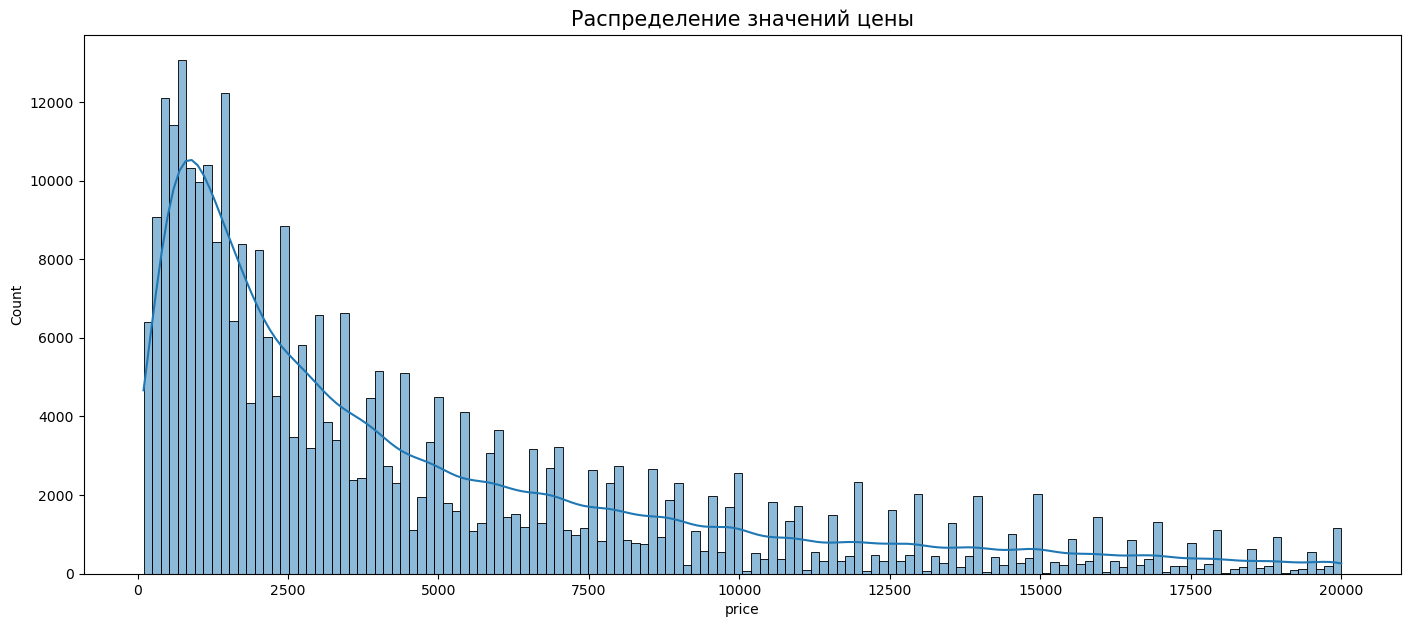

In [19]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.histplot(x='price', bins=140, kde=True, data=df, ax=ax)
plt.title('Распределение значений цены', size=15)
plt.show()

<a id=hypothesis> </a>

Похоже на распределение "хи квадрат" т.е. сумма квадратов нескольких величин, подчиняющихся нормальному распределению. Исходя из формы распределения число степеней свободы (кол-во слагаемых) невелико: 3-4 слагаемых. Тоесть можно предположить, что цена главным образом зависит от 3..4 факторов.

In [20]:
print('50% квантиль:', df[df['price']>0]['price'].quantile(.5))

50% квантиль: 2850.0


Половина значений лежат в диапазоне до 2850, заметны "всплески" на круглых значениях (1000, 2000, 2500 ... 5000... 10000 и т.д.)

#### Столбец `reg_year`

Смотрим на распределение значений в столбце `reg_year`

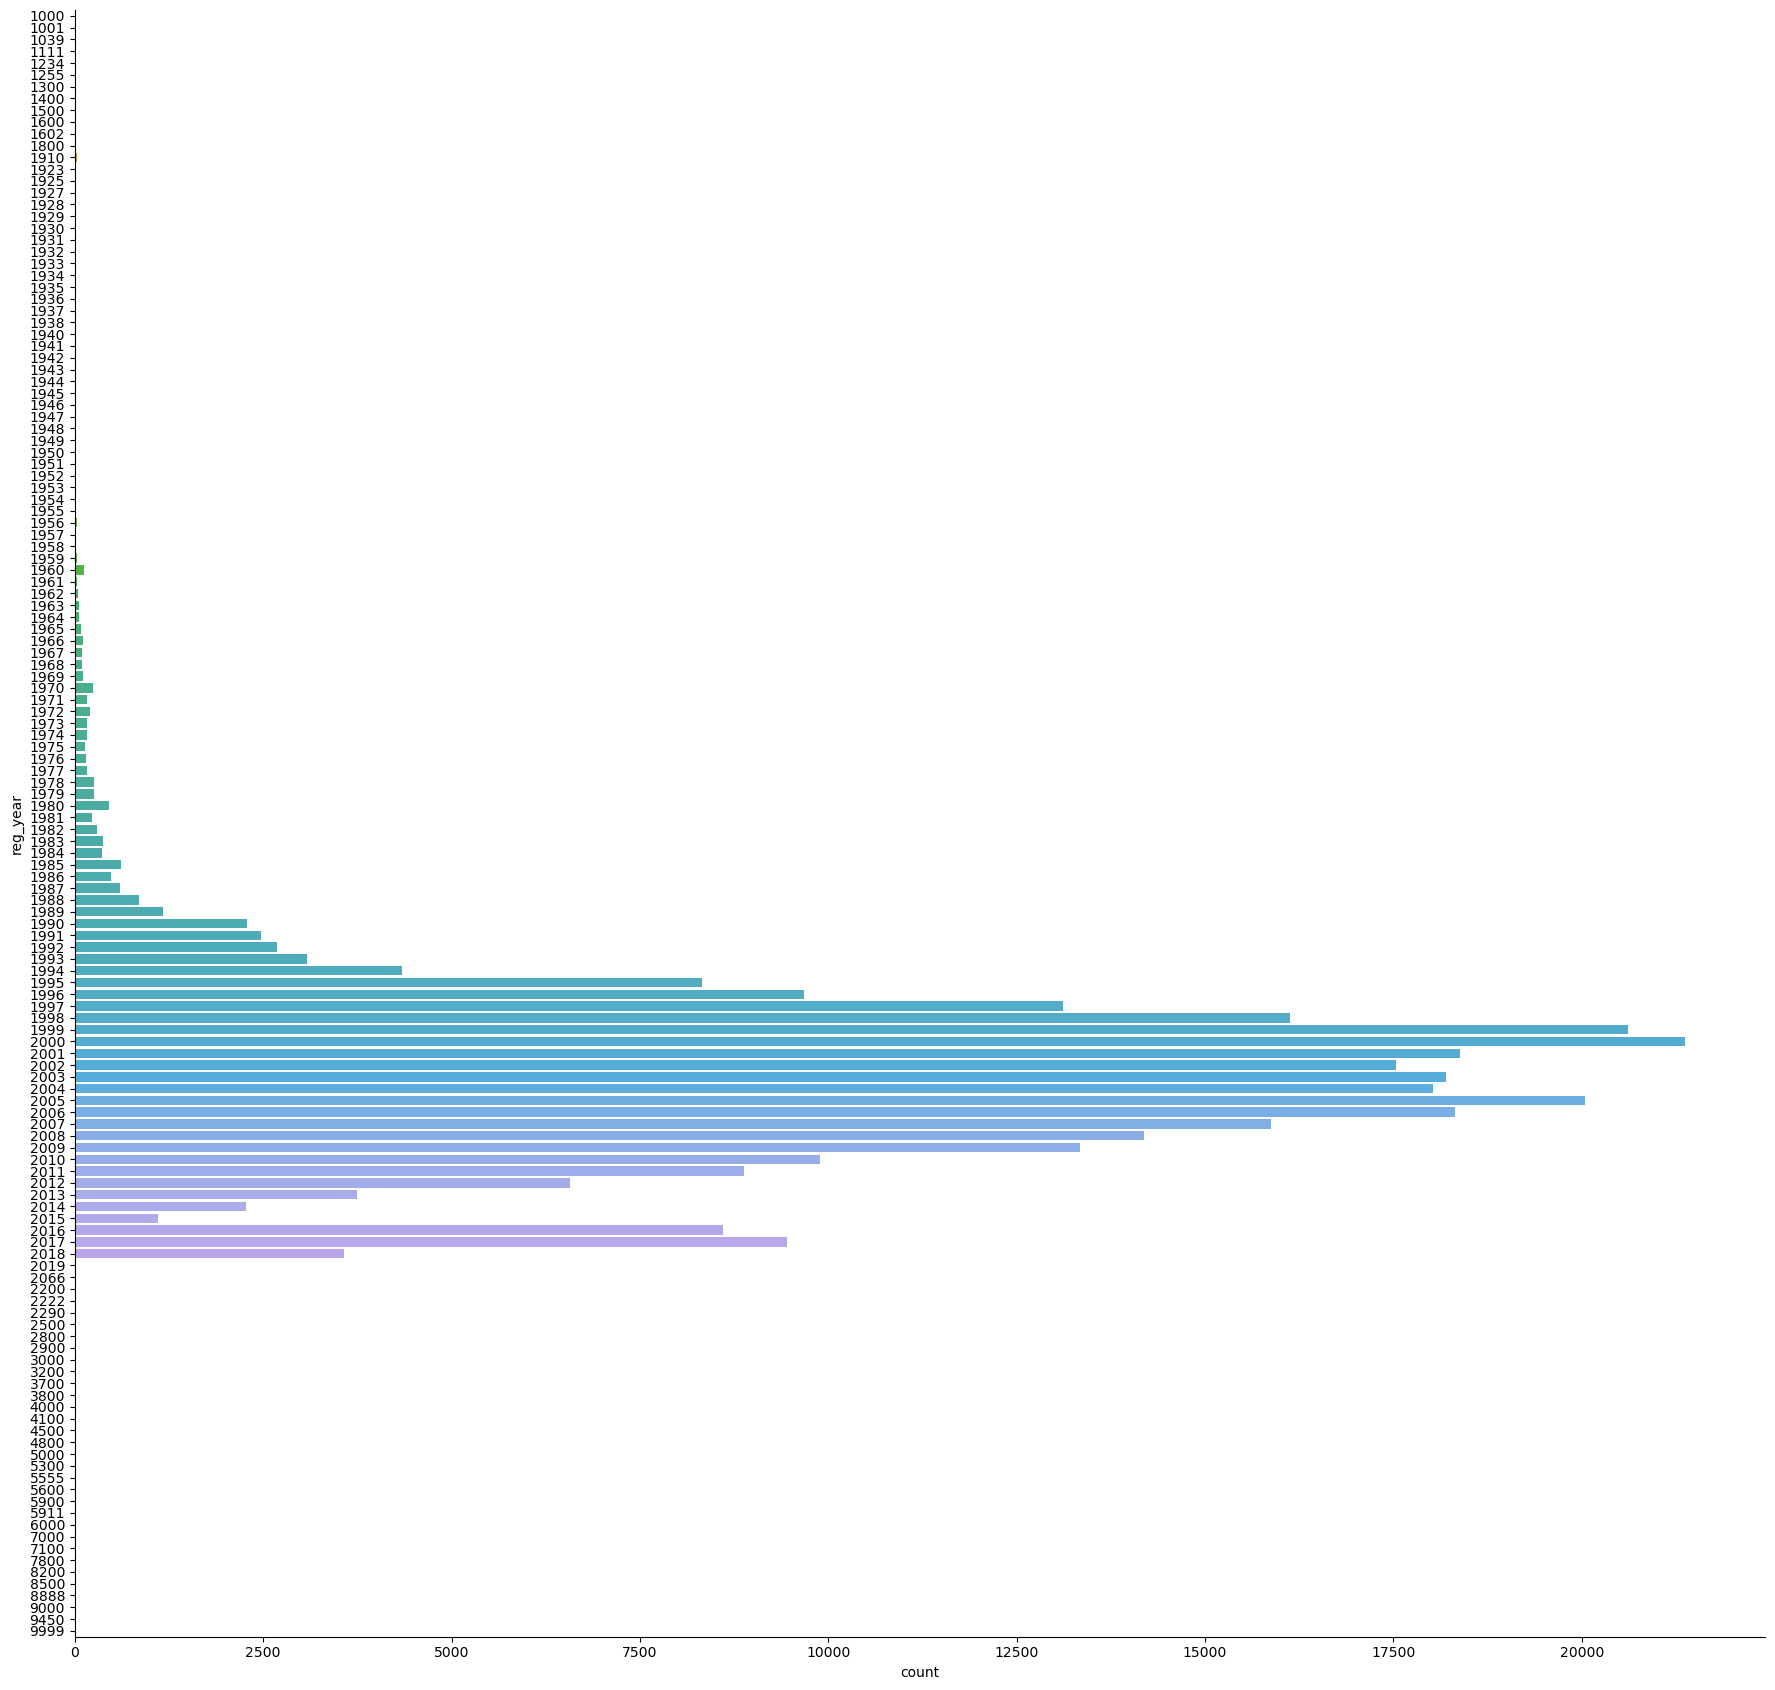

In [21]:
sns.catplot(data=df, y='reg_year', kind='count', height=17, aspect=1.05);

В данных года регистрации очевидные ошибки. Как видно основные данные лежат в диапазоне примерно от 1960 до 2018. "Отрежем" 0.5% данных (по 0.0025 квантилю "снизу" и по 0.9975 "сверху").

In [22]:
lower_limit_reg_year = df['reg_year'].quantile(0.0025)
lower_limit_reg_year

1967.0

In [23]:
upper_limit_reg_year = df['reg_year'].quantile(0.9975)
upper_limit_reg_year

2018.0

In [24]:
before = df.shape[0]
df = df[(df['reg_year'] >= lower_limit_reg_year) & (df['reg_year'] <= upper_limit_reg_year)]
after = df.shape[0]
print(
    f'Удалено строк: {before - after} или ~ {round((before - after)*100/before, 2)}% от первоначального размера'
)

Удалено строк: 871 или ~ 0.27% от первоначального размера


Переведем год регистрации в возраст авто. Это позволит снизить значение признака, но не потерять информацию.

In [25]:
df['age'] = df['reg_year'].max() - df['reg_year']

#### Столбец `model`

Посмотрим какие модели и как записаны "внутри" марок. Нас интересуют дублирования, ошибки, пропуски и т.п.

In [26]:
for brand_item in df['brand'].unique():
    print(brand_item.upper())
    print(
        'всего полей с данной маркой',
        df[df['brand'] == brand_item].index.shape[0]
    )
    
    print(
        'пропусков в названиях моделей:',
        df[df['brand'] == brand_item]['model'].isna().sum(),
        'или',
        round(
            df[df['brand'] == brand_item]['model'].isna().mean()
            * 100,
            1
        ),
        '%\n'
    )
    print(df[df['brand'] == brand_item]['model'].value_counts(), '\n')

VOLKSWAGEN
всего полей с данной маркой 69222
пропусков в названиях моделей: 2943 или 4.3 %

golf           26377
polo           11771
passat          9093
transporter     4348
touran          3143
lupo            2352
caddy           1457
sharan          1346
bora             802
beetle           753
fox              690
other            682
tiguan           582
scirocco         555
touareg          508
eos              480
kaefer           360
jetta            328
up               310
phaeton          204
cc               126
amarok            12
Name: model, dtype: int64 

AUDI
всего полей с данной маркой 26601
пропусков в названиях моделей: 1026 или 3.9 %

a4       8950
a3       5621
a6       5044
80       1411
tt        997
other     969
a1        548
a8        492
a5        479
100       359
a2        350
q7        168
90         90
q5         68
200        16
q3         13
Name: model, dtype: int64 

JEEP
всего полей с данной маркой 606
пропусков в названиях моделей: 23 или 3.8 %

пропусков в названиях моделей: 40 или 8.0 %

matiz     148
kalos      88
lanos      84
other      83
nubira     58
Name: model, dtype: int64 

ROVER
всего полей с данной маркой 431
пропусков в названиях моделей: 64 или 14.8 %

other         358
rangerover      4
discovery       2
freelander      2
defender        1
Name: model, dtype: int64 

PORSCHE
всего полей с данной маркой 655
пропусков в названиях моделей: 20 или 3.1 %

cayenne    212
boxster    206
other      157
911         60
Name: model, dtype: int64 

SAAB
всего полей с данной маркой 478
пропусков в названиях моделей: 13 или 2.7 %

other    335
900      104
9000      26
Name: model, dtype: int64 

TRABANT
всего полей с данной маркой 416
пропусков в названиях моделей: 57 или 13.7 %

601      325
other     34
Name: model, dtype: int64 

LAND_ROVER
всего полей с данной маркой 498
пропусков в названиях моделей: 13 или 2.6 %

freelander            201
range_rover            70
discovery              69
defender               68
r

Марка `rover` содержит модели, принадлежащие марке `land_rover`: `rangerover`, `freelander`, `discovery`, `defender` (у `rover` модельный ряд другой. Например можно посмотреть список моделей `rover` [тут](https://auto.ru/catalog/cars/rover/)). Название `rangerover` надо скорректировать на `range_rover` (для единообразия)

In [27]:
df['model'].replace('rangerover', 'range_rover', inplace=True)
lr_index = (df[(df['brand']=='rover') &
              ((df['model']=='range_rover')|
              (df['model']=='freelander')|
              (df['model']=='discovery')|
              (df['model']=='defender')
              )
              ].index
           )
df['brand'][lr_index] = 'land_rover'

Категория `sonstige_autos` не содержит моделей - только пропуски (2922). В переводе с немецкого `sonstige` это "прочие". Т.е. под этой категорией собран весь "мусор". Эту категорию вообще лучше удалить так как она не содержит ключевой информации, влияющей на цену - "марка, модель".

In [28]:
df.drop(df[df['brand']=='sonstige_autos'].index, inplace=True)

Для каждой марки в списке моделей присутствует поле `other` и пропуски. Заменим пропуски на `other`. Восстановить название модели не представляется возможным.

In [29]:
df['model'].fillna('other', inplace=True)

Сбрасываем дубликаты

In [30]:
df.drop_duplicates(inplace=True)

#### Столбец `gearbox`

Выведем кол-во пропусков в столбце `gearbox` и % пропусков от общего числа значений

In [31]:
df['gearbox'].isna().sum(), round(df['gearbox'].isna().mean()*100, 1)

(14775, 4.7)

Посмотрим на распределение значений:

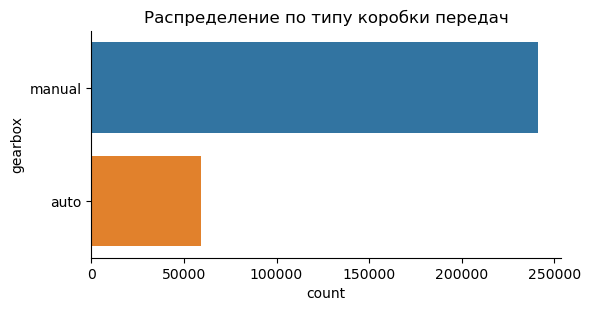

In [32]:
sns.catplot(data=df, y='gearbox', kind='count', height=3, aspect=2)
plt.title('Распределение по типу коробки передач', size=12)
plt.show()

Попробуем восстановить пропуски в столбце `gearbox`. Идея такая: для записей, где в поле `gearbox` встречается пропуск, мы будем смотреть на марку `brand` и модель `model` и для этой комбинации данных будем выбирать наиболее часто указываемый тип коробки передач.

Создадим функцию `fill_na_by_value`, которая будет возвращать `Series`, где индексы будут соответствовать индексам в датафрейме где присутствуют пропуски для выбранной колонки `col_name_to_fill`, а значения - тем значениям, на которые нужно заменить пропуски.

In [33]:
def fill_na_by_value(col_name_to_fill, col_list_to_refer, df, fillby='frequent'):

    '''
    Функция возвращает Series с проиндексированными значениями для замены пропусков в столбце col_name_to_fill
    Выбор значения для замены осуществляется по параметру 'fillby' 
    - 'frequent' - наиболее часто встречающемуся значению
    - 'median' - медианное значение
    Выбор наиболее часто встречающегося значения производится из результа аггрегации после группировки датафрейма
    по полям из списка col_list_to_refer 
    '''

    '''
    Создаем датафрейм df_refer_most_frqnt из наиболее часто встречающихся значений в поле col_name_to_fill
    для комбинаций (группировок) по столбцам, согласно списку col_list_to_refer
    '''
    if fillby == 'frequent':
        df_refer = (
            df[np.invert(df[col_name_to_fill].isna())]
            .groupby(col_list_to_refer)[col_name_to_fill]
            .agg(lambda x : x.mode().loc[lambda x : x!='all'].iloc[0] if len(x)>1 else x.mode().iloc[0])
            .to_frame()
        )
    elif fillby == 'median':
        df_refer = (
            df[np.invert(df[col_name_to_fill].isna())]
            .groupby(col_list_to_refer)[col_name_to_fill]
            .agg('median')
            .to_frame()
        )

    '''
    Создадаим датафрейм df_nan_values для значений, где есть пропуски в поле col_name_to_fill: 
    значения будут соответствовать индексам, где есть пропуск,
    а мультииндекс создадим из кортежа значений в полях из списка col_list_to_refer для данного индекса.
    '''   
    cols_to_zip = [ df[df[col_name_to_fill].isna()][col_to_refer] for col_to_refer in col_list_to_refer ] 
    tuples=list(zip(*cols_to_zip))
    
    df_nan_values = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(tuples, names=col_list_to_refer),
        data=df[df[col_name_to_fill].isna()].index
    )
    
    '''
    Соединяем два датафрейма по мультииндексам, за базу выбираем датафрейм df_nan_values
    Получим датафрейм  fillna_df где индексами будут индексы, в которых есть пропуски в столбце col_name_to_fill
    значениями будут значения для замены пропусков
    '''
    
    fillna_df = (
        df_nan_values
        .join(df_refer, how='left')
        .reset_index(drop=True)
        .set_index(0)
    )

    fillna_df.index.name = None
    fillna_ser = fillna_df.squeeze()
    
    return fillna_ser

In [34]:
gearbox_fillna_ser = fill_na_by_value('gearbox', ['brand', 'model'], df)

In [35]:
gearbox_fillna_ser.value_counts()

manual    12902
auto       1873
Name: gearbox, dtype: int64

Получилась `gearbox_fillna_ser`, где собраны все данные для заполнения. Заполняем пропуски в столбце `gearbox` значениями из `gearbox_fillna_ser`

In [36]:
df.loc[ df[df['gearbox'].isna()].index, 'gearbox' ] = gearbox_fillna_ser
df['gearbox'].isna().sum()

0

In [37]:
df.drop_duplicates(inplace=True)

Пропуски в столбце `gearbox` заполнены.

#### Столбец `fuel`

Выведем кол-во пропусков в столбце `fuel` и % пропусков от общего числа значений

In [38]:
df['fuel'].isna().sum(), round(df['fuel'].isna().mean()*100, 1)

(26720, 8.5)

Посмотрим на раcпределение значений

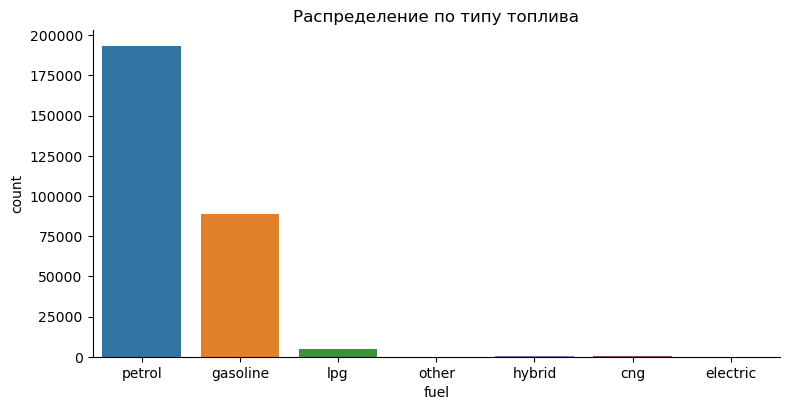

In [39]:
sns.catplot(data=df, x='fuel', kind='count', height=4, aspect=2)
plt.title('Распределение по типу топлива', size=12)
plt.show()

Применим тот же подход, что и для восстановления значений в `gearbox`. Опираться будем на признаки `brand`, `model` и `gearbox`

In [40]:
fuel_fillna_ser = fill_na_by_value('fuel', ['brand', 'model', 'gearbox'], df)

In [41]:
fuel_fillna_ser.value_counts()

petrol      22690
gasoline     4030
Name: fuel, dtype: int64

In [42]:
df.loc[ df[df['fuel'].isna()].index, 'fuel' ] = fuel_fillna_ser
df['fuel'].isna().sum()

0

In [43]:
df.drop_duplicates(inplace=True)

Пропуски в столбце `fuel` заполнены.

#### Столбец `type`

Число пропусков в столбце `type` и процент от общего числа

In [44]:
df['type'].isna().sum(), round(df['type'].isna().mean()*100, 1)

(30535, 9.7)

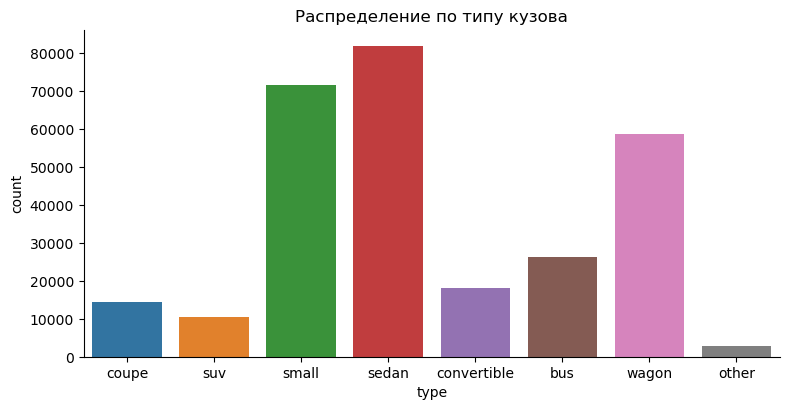

In [45]:
sns.catplot(data=df, x='type', kind='count', height=4, aspect=2)
plt.title('Распределение по типу кузова', size=12)
plt.show()

Заполняем пропуски, используя функцию `fill_na_by_value`, базируемся на признаках `brand` и `model`

In [46]:
type_fillna_ser = fill_na_by_value('type', ['brand', 'model'], df)

Распределение значений в данных для заполнения пропусков

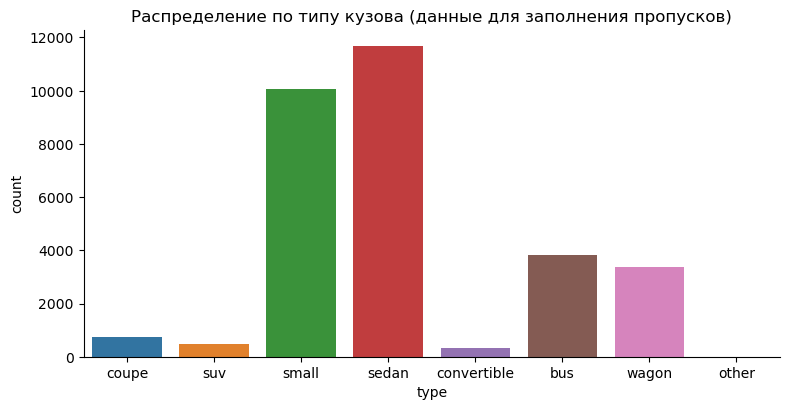

In [47]:
sns.catplot(data=type_fillna_ser.to_frame(),
            x='type',
            kind='count',
            height=4,
            aspect=2,
            order=df['type'].unique()[1:]
           )
plt.title('Распределение по типу кузова (данные для заполнения пропусков)', size=12)
plt.show()

Заполняем пропуски в столбце `type`

In [48]:
df.loc[ df[df['type'].isna()].index, 'type' ] = type_fillna_ser
df['type'].isna().sum()

0

In [49]:
df.drop_duplicates(inplace=True)

Пропуски в столбце `type` заполнены.

#### Столбец `power`

В данных мощности присутствуют аномальные значения. Очень много нулевых значений (вероятно, тот, кто заполнял анкету, не знал значение мощности).

Есть очень большие значения (свыше 1000). Отбросим 0.25% аномальных значений "сверху" и посмотрим на распределение значений на отрезке `[0, .9975q]`

In [50]:
power_up_q = 0.9975
power_dwn_q = 1 - power_up_q
upper_limit_power = round(df['power'].quantile(power_up_q))

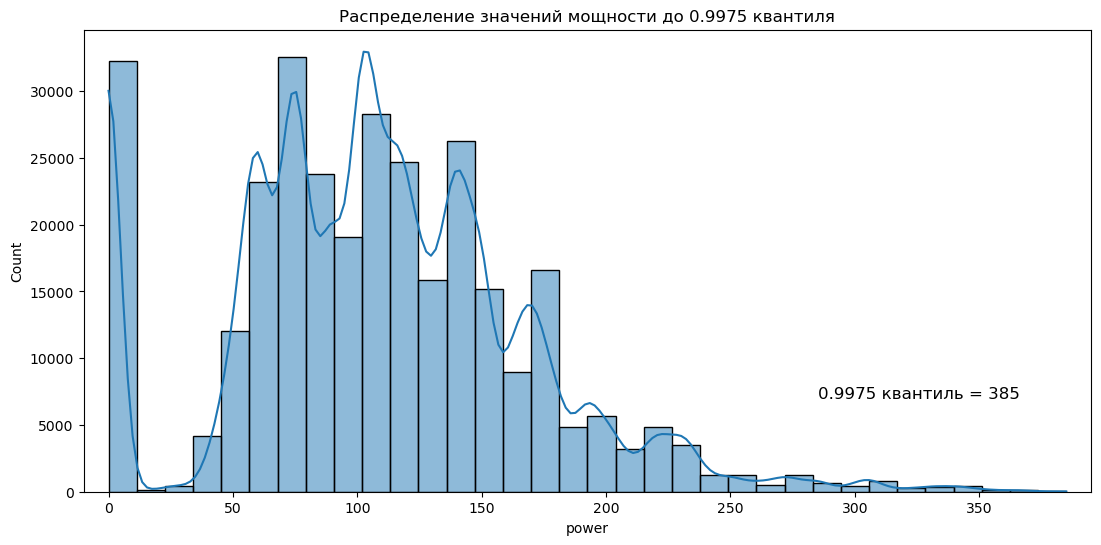

In [51]:
plt.figure(figsize=(13,6))
sns.histplot(df[df['power']<=upper_limit_power]['power'], bins=34, kde=True)
plt.xlim([-10, upper_limit_power+10])
plt.text(upper_limit_power-100, 7000, str(power_up_q)+' квантиль = '+str(upper_limit_power), fontsize=12)
plt.title('Распределение значений мощности до '+str(power_up_q)+' квантиля')
plt.show()

Удалим значения, где мощность выше `upper_limit_power`

In [52]:
before = df.shape[0]
df = df[df['power'] <= upper_limit_power]
after = df.shape[0]
print(
    f'Удалено строк: {before - after} или ~ {round((before - after)*100/before, 2)}% от первоначального размера'
)

Удалено строк: 780 или ~ 0.25% от первоначального размера


Целесообразно отбросить также 0,25% слишком малых значений (автомобилей мощностью 1, 2 или 10 л.с. не бывает). Нулевые не трогаем.

In [53]:
lower_limit_power = round(df[df['power']!=0]['power'].quantile(power_dwn_q))
lower_limit_power

34

In [54]:
before = df.shape[0]
df = df[ (df['power'] >= lower_limit_power) | (df['power'] == 0) ]
after = df.shape[0]
print(
    f'Удалено строк: {before - after} или ~ {round((before - after)*100/before, 2)}% от первоначального размера'
)

Удалено строк: 614 или ~ 0.2% от первоначального размера


Нулевые значения мощности можно восстановить, опираясь на `brand`, `model` и тип трансмиссии `gearbox`. Можно брать медианное значение мощности по трем указанным параметрам. Посмотрим у какого кол-ва моделей присутствуют нули в значении мощности.

In [55]:
zero_power_models = df[df['power'] == 0]['model'].value_counts().index
print(f'Для {len(zero_power_models)} моделей встречаются нули в значении мощности')
print(f"Всего {len(df[df['power']==0])} записей с нулевым значением мощности")

Для 242 моделей встречаются нули в значении мощности
Всего 32174 записей с нулевым значением мощности


Заменим нули в `power` на `np.nan` и применим функцию `fill_na_by_value`с параметром `fillby='median'`

In [56]:
df.loc[df['power']==0, 'power'] = np.nan
df['power'].isna().sum()

32174

In [57]:
power_fillzero_ser = round(fill_na_by_value('power', ['brand', 'model', 'gearbox'], df, fillby='median'))

In [58]:
df.loc[ df[df['power'].isna()].index, 'power' ] = power_fillzero_ser
df['power'].isna().sum()

1

Остался 1 пропуск ... посмотрим, где

In [59]:
df[df['power'].isna()]

price   type  reg_year gearbox  power    model  km      fuel  \
234296   3800  wagon      1978  manual    NaN  serie_1  30  gasoline   

             brand not_repaired  postal_code  age  
234296  land_rover          NaN        49824   40

Эта марка и модель изначально была одна в датафрейме и с нулевым значением мощности, поэтому брать медианное значение было неоткуда.

In [60]:
df[ (df['brand']=='land_rover') & (df['model']=='serie_1')]

price   type  reg_year gearbox  power    model  km      fuel  \
234296   3800  wagon      1978  manual    NaN  serie_1  30  gasoline   

             brand not_repaired  postal_code  age  
234296  land_rover          NaN        49824   40

Возьмем данные [отсюда](https://auto.ru/catalog/cars/land_rover/series_i/20347951/20469983/)

In [61]:
df.loc[df[df['power'].isna()].index, 'power' ] = 50
df[ (df['brand']=='land_rover') & (df['model']=='serie_1')]

price   type  reg_year gearbox  power    model  km      fuel  \
234296   3800  wagon      1978  manual 50.000  serie_1  30  gasoline   

             brand not_repaired  postal_code  age  
234296  land_rover          NaN        49824   40

In [62]:
df.drop_duplicates(inplace=True)

Посмотрим на распределение значений `power` после восстановления нулевых значений медианными по параметрам `brand`, `model` и `gearbox`

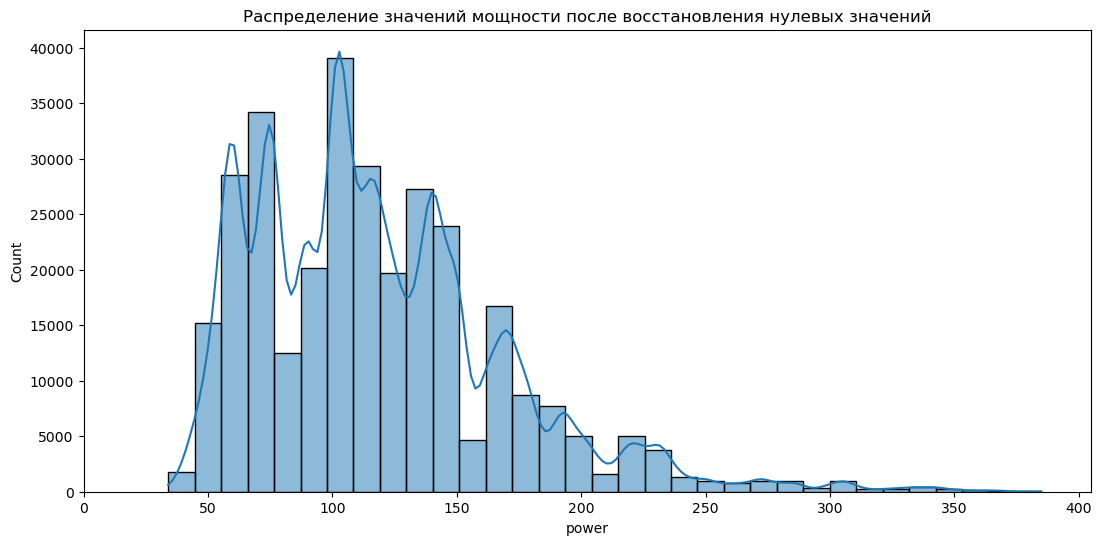

In [63]:
plt.figure(figsize=(13,6))
sns.histplot(df['power'], bins=33, kde=True)
plt.xlim([0, upper_limit_power+20])
plt.title('Распределение значений мощности после восстановления нулевых значений')
plt.show()

In [64]:
print(df['power'].quantile(.05), df['power'].quantile(.95))

55.0 218.0


Нули в столбце `power` восстановлены, основная масса значений (5 и 95 квантили) лежит в диапазоне от 55 до 218

#### Столбец `postal_code`

Попробуем конвертировать индексы в названия Земель Германии (предположение о Германии возникло, так как поколения моделей в столбце `model` указаны как **reihe** и из названия категории `sonstige_autos`. Явно немецкие пользователи заполняли). Для этого воспользуемся методом `query_postal_code` из модуля `pgeocode`. На вход этот метод может получать список индексов в `str` формате, но длина списка (выяснил экспериментально) ограничена 1000 значениями. На выходе этот метод выдает объект `series`, нам из этого объекта нужно поле с индексом `state_name`.

In [65]:
geo = pgeocode.Nominatim(COUNTRY)

Функция `make_chunk_list` разбивает `series` на куски по 1000 записей и возвращает список списков из строковых значений, получившихся из каждого куска. Плюс немного "чистим" обобщенную строку от лишних символов и добавляем нули там, где 2 пробела, так как формат индекса 5 знаковый и "лишний" пробел - это "исчезнувший" ноль в формате `int`. (ссылка на описание формата почтового кода Германии [тут](https://en.youbianku.com/Germany))

In [66]:
def make_chunk_list(series):
    prep_list = []
    chunk_list = []
    if len(series) <= CHNK_SIZE:
        prep_list.append(str(series.values)
                                 .replace('  ', ' 0')
                                 .replace('\n', '')
                                 .replace('[','')
                                 .replace(']','')
                                 .split()
                                )
    else:
        for n in range( (len(series) // CHNK_SIZE) +1):
            prep_list.append(str(series.values[n*1000:(n+1)*1000])
                              .replace('  ', ' 0')
                              .replace('\n', '')
                              .replace('[','')
                              .replace(']','')
                              .split()
                              )
    for prep_list_elem in prep_list:
        chunk_list.append( [ str('0'*(5-len(item)))+item for item in prep_list_elem ] )
            
    return chunk_list

Функция `code2name_pgeo` получает на вход список из строковых значений, возвращает список из названий Земель и `NaN` (если по индексу не удалось определить название Земли).

In [67]:
def code2name_pgeo(chunk):
    return geo.query_postal_code(chunk)['state_name']

In [68]:
state_list = []
for chunk in make_chunk_list(df['postal_code']):
    state_list.append(code2name_pgeo(chunk))

Поскольку мы удаляли строки и не "дропали" индексы, то перед созданием новой колонки надо обновить нумерацию индексов.

In [69]:
df = df.reset_index(drop=True)
df.loc[:, 'state_name'] = pd.Series( list(itertools.chain.from_iterable(state_list)) )

In [70]:
print(
    f"уникальных значений: {len(df['state_name'].value_counts()) }"
)
print(
    f"удалось конвертировать {len(df['state_name']) - df['state_name'].isna().sum()} значений или ~{round((1-df['state_name'].isna().mean())*100, 2)}%"
)
print(
    f"пропусков {df['state_name'].isna().sum()} или ~{round((df['state_name'].isna().mean())*100, 2)}%"
)

уникальных значений: 16
удалось конвертировать 312407 значений или ~99.96%
пропусков 116 или ~0.04%


С помощью примененного метода удалось распознать почти всё :)

Нераспознанное заменяем на `unknown`, приводим данные в столбце `state_name` к нижнему регистру, выводим распределение уникальных значений

In [71]:
df['state_name'] = df['state_name'].fillna('unknown').str.lower()
df['state_name'].value_counts().to_frame()

state_name
nordrhein-westfalen          75952
bayern                       46151
baden-württemberg            36142
niedersachsen                36107
hessen                       27742
rheinland-pfalz              18131
berlin                       12423
schleswig-holstein           12321
sachsen                       9428
brandenburg                   7408
hamburg                       6038
sachsen-anhalt                6035
thüringen                     5762
saarland                      5327
mecklenburg-vorpommern        4681
bremen                        2759
unknown                        116

In [72]:
print(
    f'Уникальных значений в поле postal_code: {df["postal_code"].nunique()}'
)
print(
    f'Уникальных значений в поле state_name: {df["state_name"].nunique()}'
)

Уникальных значений в поле postal_code: 8137
Уникальных значений в поле state_name: 17


В итоге, вместо **8+ тыс. вариантов** в поле `postal_code` мы получили **17 вариантов** в поле `state_name`.

#### Столбец `not_repaired`

В этом столбце самое большое кол-во пропусков. Посмотрим на распределение данных:

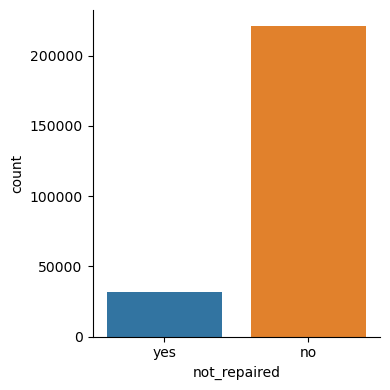

In [73]:
sns.catplot(data=df,
            x='not_repaired',
            kind='count',
            height=4,
            aspect=1,
            order=['yes', 'no']
           );

Очень много значений `no`. Можно было бы заполнить пропуски этим значением.
Попробуем заполнить пропуски опираясь на марку, модель, мощность и возраст автомобиля. Возраст будем определять по году регистрации `reg_year`.

Переведем данные возраста и мощности в категории, а затем воспользуемся функцией `fill_na_by_value` заполнив пропуски наиболее часто встречающимся значением для данной комбинации факторов.

In [74]:
df.loc[:, 'power_cat'] = pd.cut(
    df['power'], 6, labels=['vegan', 'low', 'medium', 'serious', 'high', 'beast']
)
df.loc[:, 'age_cat'] = pd.cut(
    df['reg_year'], 5, labels=['fossil', 'old', 'mature', 'youth', 'new']
)
repaired_fillna_ser = fill_na_by_value(
    'not_repaired', ['age_cat', 'power_cat', 'brand', 'model'], df
)

In [75]:
repaired_fillna_ser.value_counts()

no     59276
yes       87
Name: not_repaired, dtype: int64

Как видим, некая дифференциация все-таки существует :) Заполняем пропуски.

In [76]:
df.loc[ df[df['not_repaired'].isna()].index, 'not_repaired' ] = repaired_fillna_ser
df['not_repaired'].isna().sum()

155

Оставшееся пропуски заполним значением `no`

In [77]:
df.loc[ df[df['not_repaired'].isna()].index, 'not_repaired' ] = 'no'
df['not_repaired'].isna().sum()

0

In [78]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

Пропуски в столбце `not_repaired` заполнены.

#### Оптимизация размера данных

Для уменьшения размера датафрейма целесообразно оптимизировать типы данных, удалить лишнее. Имеем следующие вводные:

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309378 entries, 0 to 309377
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         309378 non-null  int64   
 1   type          309378 non-null  object  
 2   reg_year      309378 non-null  int64   
 3   gearbox       309378 non-null  object  
 4   power         309378 non-null  float64 
 5   model         309378 non-null  object  
 6   km            309378 non-null  int64   
 7   fuel          309378 non-null  object  
 8   brand         309378 non-null  object  
 9   not_repaired  309378 non-null  object  
 10  postal_code   309378 non-null  int64   
 11  age           309378 non-null  int64   
 12  state_name    309378 non-null  object  
 13  power_cat     309378 non-null  category
 14  age_cat       309378 non-null  category
dtypes: category(2), float64(1), int64(5), object(7)
memory usage: 31.3+ MB


In [80]:
df[df.columns].nunique()

price           3648
type               8
reg_year          52
gearbox            2
power            338
model            249
km                13
fuel               7
brand             39
not_repaired       2
postal_code     8137
age               52
state_name        17
power_cat          6
age_cat            5
dtype: int64

In [81]:
def tune_types(df, types2select, types2convert):
    optimal_types = df.select_dtypes(include=[types2select]).apply(pd.to_numeric, downcast=types2convert)
    
# меняем типы в столбцах, которые являются индексами в Series optimal_types
# итерируемся по индексам Series (названия столбцов) и обращаемся к значениям по индексу (тип данных)
    
    for item in optimal_types.dtypes.index:
        df.loc[:, item] = df[item].astype(optimal_types.dtypes[item])

In [82]:
tune_types(df, types2select='integer', types2convert='integer')
tune_types(df, types2select='float', types2convert='integer')

В столбцах `type`, `gearbox`, `model`, `km`, `fuel`, `brand`, `not_repaired`, `state_name` приведем данные к типу `category`

In [83]:
cols_to_cat = ['type', 'gearbox', 'model', 'km', 'fuel', 'brand', 'not_repaired', 'state_name']
df[cols_to_cat] = df[cols_to_cat].astype('category')

In [84]:
df.drop(['power_cat', 'age_cat', 'postal_code', 'reg_year'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309378 entries, 0 to 309377
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         309378 non-null  int16   
 1   type          309378 non-null  category
 2   gearbox       309378 non-null  category
 3   power         309378 non-null  int16   
 4   model         309378 non-null  category
 5   km            309378 non-null  category
 6   fuel          309378 non-null  category
 7   brand         309378 non-null  category
 8   not_repaired  309378 non-null  category
 9   age           309378 non-null  int8    
 10  state_name    309378 non-null  category
dtypes: category(8), int16(2), int8(1)
memory usage: 4.1 MB


Размер датафрейма уменьшился с 31.5+ MB до 4.2 MB

### Вывод

Данные подготовлены:
- в столбце `price` удалены нулевые значения и значения менее 100;
- в столбце `reg_year` выбраны значения в диапазоне квантилей [0.0025, 0,9975]. Конвертирован в данные возраста авто `age`;
- в столбце `model` исправлены ошибки, пропуски заполнены значением `other` и удалена "мусорная" категория `sonstige_autos`;
- в столбце `gearbox` восстановлены пропуски по частоте значения для критериев марка `brand`, модель `model`;
- в столбце `fuel` восстановлены пропуски по частоте значения для критериев марка `brand`, модель `model` и тип коробки передач `gearbox`;
- в столбце `type` восстановлены пропуски по частоте значения для критериев марка `brand`, модель `model`;
- в столбце `power` выбраны значения в диапазоне квантилей [0.0025, 0,9975]. Восстановлены нулевые значения по медиане значения для критериев марка `brand`, модель `model` и тип коробки передач `gearbox`;
- значения столбца `postal_code` конвертированы в названия административных единиц. Значения сохранены в новой колонке `state_name`. Вместо 8+ тыс. вариантов в поле `postal_code` мы получили 17 вариантов в поле `state_name`;
- в столбце `not_repaired` восстановлены пропуски по частоте значения для критериев категории возраста `age_cat`, категории мощности `power_cat`, марки `brand` и модели `model`;
- уменьшен размер датафрейма с 31.5+ MB до 4.2 MB;

## Обучение моделей

Выберем следующие регрессоры для обучения модели:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

Оценивать будем по метрике `RMSE`. Качество моделей будем проверять на кроссвалидации на тренировочных данных.

Признаки сделаем в двух вариантах: "как есть" и с **OHE**-кодированием категориальных столбцов.

In [85]:
fch = df.drop('price', axis=1)
trgt = df['price']

fch_train, fch_test, trgt_train, trgt_test = train_test_split(
    fch, trgt, test_size=TRN_TST_RATIO, random_state=RND_ST
)

cat_columns = df.select_dtypes(include='category').columns
ohe_fch_train = pd.get_dummies(fch_train, columns=cat_columns, drop_first=True)
ohe_fch_test = pd.get_dummies(fch_test, columns=cat_columns, drop_first=True)

Удаляем переменные, которые более не нужны

In [86]:
del df
del geo
del repaired_fillna_ser
del power_fillzero_ser
del type_fillna_ser
del fuel_fillna_ser
del gearbox_fillna_ser

Функция для определения времени исполнения ячейки и функция для замера метрики на кроссвалидации

In [88]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RND_ST)

In [89]:
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    s, m = int(round(s, 0)), int(round(m, 0))
    print("Execution Time: " + "{0:02d} min {1:02d} sec".format(m, s))
    return diff_time

In [90]:
def exec_cv(model, name, fch, trg, kf=kf):
    start = time.time()
    cv_scores = (cross_val_score(model,
                                 fch,
                                 trg,
                                 cv=kf,
                                 scoring='neg_root_mean_squared_error',
                                 verbose=3)
            )*(-1)
    end = time.time()

    print(name)
    cv_scores_mean = cv_scores.mean()
    print(f"Среднее значение RMSE = {round(cv_scores_mean, 1)}")
    cv_time = exec_time(start, end)
    return cv_scores_mean, cv_time

### LinearRegression

Замерим метрику **RMSE** на кросс-валидации на тренировочных данных для модели `LinearRegression()` на **OHE** без масштабирования. Масштабирование не обязательно так как L1 и L2 регуляризация не применяется.

In [91]:
LRModel = LinearRegression()
LR_RMSE_OHE_mean, cv_LR_OHE_time = exec_cv(LRModel,
                                          'LinearRegression (OHE)',
                                           ohe_fch_train,
                                           trgt_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-2611.402) total time=   7.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] END ............................ score: (test=-2592.369) total time=   6.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV] END ............................ score: (test=-2584.150) total time=   5.3s
[CV] END ............................ score: (test=-2566.108) total time=   5.4s
[CV] END ............................ score: (test=-2608.962) total time=   5.4s
LinearRegression (OHE)
Среднее значение RMSE = 2592.6
Execution Time: 00 min 30 sec


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.7s finished


Значение метрики не очень обнадеживающее ... 

### DecisionTreeRegressor

Подберем гиперпараметры и замерим метрику **RMSE** на кроссвалидации для `DecisionTreeRegressor()`, используя класс `GridSearchCV()`.

Данные с **OHE**, масштабирование для деревьев не нужно.

In [92]:
DTModel = DecisionTreeRegressor(random_state=RND_ST) 

DT_paramgrid = {'max_depth': list(range(26, 28)),          
                'min_samples_split': list(range(40, 56, 5)),             
                'min_samples_leaf':list(range(4, 7))
               } 
DTGC = GridSearchCV(DTModel,
                    DT_paramgrid,
                    cv=kf,
                    scoring='neg_root_mean_squared_error',
                    verbose=4)

DTGC.fit(ohe_fch_train, trgt_train)

print(f'Оптимальное значение depth: {DTGC.best_params_["max_depth"]}')
print(f'Оптимальное значение min_samples_split: {DTGC.best_params_["min_samples_split"]}')
print(f'Оптимальное значение min_sample_leaf: {DTGC.best_params_["min_samples_leaf"]}\n')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=26, min_samples_leaf=4, min_samples_split=40;, score=-1811.829 total time=   6.4s
[CV 2/5] END max_depth=26, min_samples_leaf=4, min_samples_split=40;, score=-1807.002 total time=   6.8s
[CV 3/5] END max_depth=26, min_samples_leaf=4, min_samples_split=40;, score=-1812.641 total time=   6.4s
[CV 4/5] END max_depth=26, min_samples_leaf=4, min_samples_split=40;, score=-1792.056 total time=   6.6s
[CV 5/5] END max_depth=26, min_samples_leaf=4, min_samples_split=40;, score=-1827.580 total time=   6.9s
[CV 1/5] END max_depth=26, min_samples_leaf=4, min_samples_split=45;, score=-1808.548 total time=   6.2s
[CV 2/5] END max_depth=26, min_samples_leaf=4, min_samples_split=45;, score=-1804.738 total time=   6.7s
[CV 3/5] END max_depth=26, min_samples_leaf=4, min_samples_split=45;, score=-1813.488 total time=   6.4s
[CV 4/5] END max_depth=26, min_samples_leaf=4, min_samples_split=45;, score=-1793.978 total time= 

[CV 4/5] END max_depth=27, min_samples_leaf=4, min_samples_split=55;, score=-1796.177 total time=   6.5s
[CV 5/5] END max_depth=27, min_samples_leaf=4, min_samples_split=55;, score=-1829.449 total time=   6.4s
[CV 1/5] END max_depth=27, min_samples_leaf=5, min_samples_split=40;, score=-1806.085 total time=   6.3s
[CV 2/5] END max_depth=27, min_samples_leaf=5, min_samples_split=40;, score=-1804.038 total time=   6.4s
[CV 3/5] END max_depth=27, min_samples_leaf=5, min_samples_split=40;, score=-1810.788 total time=   6.5s
[CV 4/5] END max_depth=27, min_samples_leaf=5, min_samples_split=40;, score=-1788.410 total time=   6.6s
[CV 5/5] END max_depth=27, min_samples_leaf=5, min_samples_split=40;, score=-1824.072 total time=   6.5s
[CV 1/5] END max_depth=27, min_samples_leaf=5, min_samples_split=45;, score=-1803.437 total time=   6.3s
[CV 2/5] END max_depth=27, min_samples_leaf=5, min_samples_split=45;, score=-1800.187 total time=   6.5s
[CV 3/5] END max_depth=27, min_samples_leaf=5, min_samp

In [93]:
DTModel = DecisionTreeRegressor(max_depth=DTGC.best_params_['max_depth'],
                                min_samples_split=DTGC.best_params_['min_samples_split'],
                                min_samples_leaf=DTGC.best_params_['min_samples_leaf'],
                                random_state=RND_ST)

In [94]:
DT_OHE_RMSE_mean, cv_DT_OHE_time = exec_cv(DTModel,
                                           'DecisionTreeRegressor (OHE)',
                                           ohe_fch_train,
                                           trgt_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-1805.634) total time=   6.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] END ............................ score: (test=-1802.738) total time=   6.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV] END ............................ score: (test=-1811.085) total time=   6.3s
[CV] END ............................ score: (test=-1781.903) total time=   6.6s
[CV] END ............................ score: (test=-1824.748) total time=   6.2s
DecisionTreeRegressor (OHE)
Среднее значение RMSE = 1805.2
Execution Time: 00 min 32 sec


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.3s finished


Модель `DecisionTreeRegressor()` показывет лучшee **RMSE**, чем модель `LinearRegression()`

Выведем данные `DecisionTreeRegressor` по важности признаков

In [95]:
DTModel.fit(ohe_fch_train, trgt_train)
pd.DataFrame({'feature_importance': DTModel.feature_importances_, 
              'feature_name': ohe_fch_train.columns.to_list()}).sort_values(by=['feature_importance'],
                                                               ascending=False).head(21)

feature_importance         feature_name
1                 0.550                  age
0                 0.289                power
269               0.049               km_150
2                 0.015     type_convertible
232               0.011    model_transporter
314               0.011     not_repaired_yes
312               0.006     brand_volkswagen
276               0.006           brand_audi
295               0.005  brand_mercedes_benz
277               0.005            brand_bmw
271               0.003        fuel_gasoline
7                 0.003             type_suv
3                 0.003           type_coupe
8                 0.003           type_wagon
9                 0.003       gearbox_manual
296               0.002           brand_mini
268               0.002               km_125
275               0.002          fuel_petrol
5                 0.001           type_sedan
6                 0.001           type_small
299               0.001           brand_opel

Поскольку данные с **OHE** кодированием, выглядит не очень информативно. Однако можно увидеть, что признаки `age` и `power` занимают первые места по значимости.

### CatBoostRegressor

Модель `CatBoostRegressor()` будем обучать на признаках с указанием списка категориальных признаков. Создадим модель и класс данных `Pool`

In [96]:
CBRModel = CatBoostRegressor(random_state=RND_ST, verbose=False)
CBRPool_fch_train = Pool(
    data=fch_train,
    label=trgt_train,
    cat_features=list(cat_columns)
)

Подберем оптимальные параметры для модели, используя метод `grid_search` 

In [97]:
CBR_paramgrid = {'iterations':[500, 1500, 1000],
                 'learning_rate':[.3, .2, .1],
                 'depth':[6, 8, 7]
                }

CBR_grid_search_result = CBRModel.grid_search(param_grid=CBR_paramgrid,
                                              X=CBRPool_fch_train,
                                              cv=kf,
                                              plot=True,
                                              verbose=False)

print(f'Оптимальное значение iterations: {CBRModel.get_all_params()["iterations"]}')
print(f'Оптимальное значение learning_rate: {CBRModel.get_all_params()["learning_rate"]}')
print(f'Оптимальное значение depth: {CBRModel.get_all_params()["depth"]}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1641.252772
bestIteration = 499


bestTest = 1647.941643
bestIteration = 499


bestTest = 1666.877997
bestIteration = 499


bestTest = 1620.449888
bestIteration = 1497


bestTest = 1618.510233
bestIteration = 1483


bestTest = 1628.532455
bestIteration = 1498


bestTest = 1626.721164
bestIteration = 963


bestTest = 1627.427882
bestIteration = 980


bestTest = 1641.442116
bestIteration = 999


bestTest = 1627.922957
bestIteration = 488


bestTest = 1618.551205
bestIteration = 496


bestTest = 1639.750354
bestIteration = 499


bestTest = 1617.899882
bestIteration = 1345


bestTest = 1602.131535
bestIteration = 1489


bestTest = 1608.326639
bestIteration = 1498


bestTest = 1620.080891
bestIteration = 992


bestTest = 1605.83911
bestIteration = 999


bestTest = 1617.445216
bestIteration = 999


bestTest = 1634.218068
bestIteration = 494


bestTest = 1640.317162
bestIteration = 499


bestTest = 1652.038791
bestIteration = 499


bestTest = 1619.047542
bestIteration = 1446


bes

Замерим метрику и время кроссвалидации модели с оптимальными гиперпараметрами на тренировочных данных

In [98]:
start = time.time()
cv_CBR_scores = cv(CBRPool_fch_train,
                   CBRModel.get_all_params(),
                   folds=kf,
                   plot=True,
                   verbose=False)
end = time.time()

print('CatBoostRegressor')
CBR_RMSE_mean = cv_CBR_scores['test-RMSE-mean'].min()
print(f"Среднее значение RMSE = {round(CBR_RMSE_mean, 1)}")
cv_CBR_time = exec_time(start, end)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1623.963947
bestIteration = 1489

Training on fold [1/5]

bestTest = 1612.130494
bestIteration = 1455

Training on fold [2/5]

bestTest = 1596.331729
bestIteration = 1498

Training on fold [3/5]

bestTest = 1583.110039
bestIteration = 1498

Training on fold [4/5]

bestTest = 1628.058804
bestIteration = 1486

CatBoostRegressor
Среднее значение RMSE = 1608.9
Execution Time: 36 min 23 sec


Метрика **RMSE** у `CatBoostRegressor` лучше, чем у `LinearRegression` и `DecisionTreeRegressor`... но время кроссвалидации на тех же самых фолдах больше в разы.

Выведем данные по важности признаков:

In [99]:
pd.DataFrame({'feature_importance': CBRModel.get_feature_importance(CBRPool_fch_train), 
              'feature_name': fch_train.columns}
            ).sort_values(by=['feature_importance'], ascending=False)

feature_importance  feature_name
8              38.658           age
2              24.015         power
4              10.439            km
6               9.334         brand
0               6.037          type
3               5.101         model
5               2.650          fuel
7               1.810  not_repaired
9               1.336    state_name
1               0.620       gearbox

Влияние возраста `age` автомобиля и мощности `power` на цену совокупно более 65%, а вместе с маркой `brand` и пробегом `km` более 80%. [Гипотеза](#hypothesis) о том, что распределение цены похоже на распределение "хи-квадрат" со степенью свободы 3-4 кажется вполне правдоподобной.

### LGBMRegressor

Замерим метрику **RMSE** на кросс-валидации на тренировочных данных для модели `LGBMRegressor`

In [100]:
LGBModel = LGBMRegressor(random_state=RND_ST)

In [101]:
LGB_paramgrid = {'num_iterations':[500, 1500, 1000], 
                 'num_leaves': [30, 50, 70],
                 'max_depth': [6, 8, 7],
                 'learning_rate':[.2, .1, .3]} 

LGBGC = GridSearchCV(LGBModel,
                     LGB_paramgrid,
                     cv=kf,
                     scoring='neg_root_mean_squared_error',
                     verbose=4)

LGBGC.fit(fch_train, trgt_train)

print(f'Оптимальное значение num_iterations: {LGBGC.best_params_["num_iterations"]}')
print(f'Оптимальное значение num_leaves: {LGBGC.best_params_["num_leaves"]}')
print(f'Оптимальное значение learning_rate: {LGBGC.best_params_["learning_rate"]}\n')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=30;, score=-1636.746 total time=   2.4s
[CV 2/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=30;, score=-1628.423 total time=   2.6s
[CV 3/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=30;, score=-1604.809 total time=   2.5s
[CV 4/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=30;, score=-1590.403 total time=   3.1s
[CV 5/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=30;, score=-1638.811 total time=   2.5s
[CV 1/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=50;, score=-1628.104 total time=   3.2s
[CV 2/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=50;, score=-1626.483 total time=   3.5s
[CV 3/5] END learning_rate=0.2, max_depth=6, num_iterations=500, num_leaves=50;, score=-1599.466 total time=   3.2s
[CV 4/5] E

[CV 1/5] END learning_rate=0.2, max_depth=8, num_iterations=1500, num_leaves=70;, score=-1639.345 total time=  11.5s
[CV 2/5] END learning_rate=0.2, max_depth=8, num_iterations=1500, num_leaves=70;, score=-1639.507 total time=  11.6s
[CV 3/5] END learning_rate=0.2, max_depth=8, num_iterations=1500, num_leaves=70;, score=-1599.306 total time=  11.9s
[CV 4/5] END learning_rate=0.2, max_depth=8, num_iterations=1500, num_leaves=70;, score=-1607.704 total time=  12.5s
[CV 5/5] END learning_rate=0.2, max_depth=8, num_iterations=1500, num_leaves=70;, score=-1633.723 total time=  12.0s
[CV 1/5] END learning_rate=0.2, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1626.526 total time=   4.8s
[CV 2/5] END learning_rate=0.2, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1626.711 total time=   4.4s
[CV 3/5] END learning_rate=0.2, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1594.715 total time=   4.5s
[CV 4/5] END learning_rate=0.2, max_depth=8, num_iterations=1000

[CV 2/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=50;, score=-1620.377 total time=   3.2s
[CV 3/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=50;, score=-1595.336 total time=   3.3s
[CV 4/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=50;, score=-1583.164 total time=   3.8s
[CV 5/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=50;, score=-1632.838 total time=   3.2s
[CV 1/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=70;, score=-1626.120 total time=   3.4s
[CV 2/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=70;, score=-1619.501 total time=   3.3s
[CV 3/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=70;, score=-1595.066 total time=   3.6s
[CV 4/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_leaves=70;, score=-1583.558 total time=   3.7s
[CV 5/5] END learning_rate=0.1, max_depth=6, num_iterations=500, num_lea

[CV 3/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1584.655 total time=   5.4s
[CV 4/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1576.605 total time=   4.6s
[CV 5/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=30;, score=-1620.697 total time=   4.5s
[CV 1/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1608.586 total time=   6.7s
[CV 2/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1610.092 total time=   6.0s
[CV 3/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1584.721 total time=   6.3s
[CV 4/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1574.332 total time=   6.3s
[CV 5/5] END learning_rate=0.1, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1617.304 total time=   5.8s
[CV 1/5] END learning_rate=0.1, max_depth=8, num_iterations=1000

[CV 4/5] END learning_rate=0.3, max_depth=6, num_iterations=500, num_leaves=70;, score=-1601.171 total time=   3.2s
[CV 5/5] END learning_rate=0.3, max_depth=6, num_iterations=500, num_leaves=70;, score=-1647.400 total time=   3.2s
[CV 1/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=30;, score=-1652.528 total time=   8.1s
[CV 2/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=30;, score=-1646.507 total time=   7.5s
[CV 3/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=30;, score=-1611.870 total time=   8.1s
[CV 4/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=30;, score=-1610.040 total time=   7.4s
[CV 5/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=30;, score=-1654.655 total time=   8.1s
[CV 1/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, num_leaves=50;, score=-1660.671 total time=  11.0s
[CV 2/5] END learning_rate=0.3, max_depth=6, num_iterations=1500, 

[CV 5/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=50;, score=-1651.875 total time=   5.7s
[CV 1/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=70;, score=-1655.233 total time=   6.6s
[CV 2/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=70;, score=-1660.836 total time=   7.3s
[CV 3/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=70;, score=-1625.863 total time=   6.6s
[CV 4/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=70;, score=-1626.008 total time=   6.7s
[CV 5/5] END learning_rate=0.3, max_depth=8, num_iterations=1000, num_leaves=70;, score=-1658.706 total time=   6.8s
[CV 1/5] END learning_rate=0.3, max_depth=7, num_iterations=500, num_leaves=30;, score=-1642.477 total time=   2.4s
[CV 2/5] END learning_rate=0.3, max_depth=7, num_iterations=500, num_leaves=30;, score=-1636.888 total time=   2.3s
[CV 3/5] END learning_rate=0.3, max_depth=7, num_iterations=500, n

In [102]:
LGBModel = LGBMRegressor(num_iterations = LGBGC.best_params_['num_iterations'],
                         num_leaves = LGBGC.best_params_['num_leaves'],
                         learning_rate = LGBGC.best_params_['learning_rate'],
                         max_depth = LGBGC.best_params_['max_depth'],
                         random_state = RND_ST)

In [103]:
LGBM_RMSE_mean, cv_LGBM_time = exec_cv(LGBModel,
                                       'LGBMRegressor',
                                       fch_train,
                                       trgt_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-1610.100) total time=   7.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END ............................ score: (test=-1609.161) total time=   8.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV] END ............................ score: (test=-1577.755) total time=   7.4s
[CV] END ............................ score: (test=-1573.517) total time=   7.7s
[CV] END ............................ score: (test=-1608.233) total time=   7.1s
LGBMRegressor
Среднее значение RMSE = 1595.8
Execution Time: 00 min 38 sec


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.2s finished


Среднее значение метрики **RMSE** у `LGBMRegressor` сопоставимо с `CatBoostRegressor`. Но времени на гридсёрч и на кроссвалидацию тратится меньше.

Выведем данные `LGBMRegressor` по важности признаков

In [104]:
LGBModel.fit(fch_train, trgt_train)
pd.DataFrame({'feature_importance': LGBModel.feature_importances_, 
              'feature_name': fch_train.columns}
            ).sort_values(by=['feature_importance'], ascending=False).head(21)

feature_importance  feature_name
2               20673         power
8               19495           age
3                8262         model
9                5942    state_name
4                4841            km
6                2690         brand
0                2206          type
1                1790       gearbox
5                 790          fuel
7                 783  not_repaired

## Вывод

Исследованы 4 модели регрессии, найдены оптимальные параметры моделей, проведены замеры метрики **RMSE** на кроссвалидации на различных типах тренировочных данных. Параметры моделей, средние значения метрик и время выполнения кроссвалидации зафиксированы в переменных.

Модели градиентного бустинга `CatBoostRegressor` и `LGBMRegressor` показывают лучшие метрики, нежели две предыдущие простые модели и сравнимы по значению метрик друг с другом. Время, требуемое на кроссвалидацию `CatBoostRegressor` кратно выше, чем у `LGBMRegressor`.

## Анализ моделей

В данном разделе необходимо сравнить модели по 3-м ключевым требованиям заказчика:
- качество предсказания;
- скорость предсказания;
- время обучения.

Для анализа создадим список моделей и функцию `model_casting`, которая будет возвращать список из названия модели, описания данных, значения метрики и времени прогноза и обучения в секундах

In [105]:
models = []
models.append(['LinearRegression', LRModel])
models.append(['DecisionTreeRegressor', DTModel])
models.append(['CatBoostRegressor', CBRModel])
models.append(['LGBMRegressor', LGBModel])

In [106]:
def model_casting(model, data_description, data_bundle):

    if model[0] == 'CatBoostRegressor':
        start = time.time()
        model[1].fit(data_bundle[0])
        end = time.time()
    else:
        start = time.time()
        model[1].fit(data_bundle[0], data_bundle[1])
        end = time.time()
    
    print('ОБУЧЕНИЕ:', model[0],  data_description)
    fit_time = exec_time(start, end)

    if model[0] == 'CatBoostRegressor':
        start = time.time()
        model[1].predict(data_bundle[1])
        end = time.time()
        rmse = min(model[1].eval_metrics(data_bundle[1], 'RMSE')['RMSE'])
    else:
        start = time.time()
        predict = model[1].predict(data_bundle[2])
        end = time.time()
        rmse = mean_squared_error(data_bundle[3], predict, squared=False)
    
    print('ПРОГНОЗ:', model[0],  data_description)
    pred_time = exec_time(start, end)

    print('RMSE:', round(rmse ,1))
    
    return [model[0], data_description, rmse, pred_time, fit_time]

### Анализ LinearRegression и DecisionTreeRegressor

In [107]:
data_bundle_ohe = [ohe_fch_train, trgt_train, ohe_fch_test, trgt_test]

In [108]:
lr_OHE_casting = model_casting(models[0], '(OHE)', data_bundle_ohe)

ОБУЧЕНИЕ: LinearRegression (OHE)
Execution Time: 00 min 09 sec
ПРОГНОЗ: LinearRegression (OHE)
Execution Time: 00 min 00 sec
RMSE: 2613.5


In [109]:
dt_OHE_casting = model_casting(models[1], '(OHE)', data_bundle_ohe)

ОБУЧЕНИЕ: DecisionTreeRegressor (OHE)
Execution Time: 00 min 08 sec
ПРОГНОЗ: DecisionTreeRegressor (OHE)
Execution Time: 00 min 00 sec
RMSE: 1785.0


### Анализ CatBoostRegressor и LGBMRegressor

In [110]:
CBRPool_fch_test = Pool(
    data=fch_test,
    label=trgt_test,
    cat_features=list(cat_columns)
)
cbr_pool_bundle = [CBRPool_fch_train, CBRPool_fch_test]
data_bundle = [fch_train, trgt_train, fch_test, trgt_test]

In [111]:
cbr_casting = model_casting(models[2], '(Original data)', cbr_pool_bundle)

ОБУЧЕНИЕ: CatBoostRegressor (Original data)
Execution Time: 07 min 27 sec
ПРОГНОЗ: CatBoostRegressor (Original data)
Execution Time: 00 min 01 sec
RMSE: 1597.0


In [112]:
lgbr_casting = model_casting(models[3], '(Original data)', data_bundle)

ОБУЧЕНИЕ: LGBMRegressor (Original data)
Execution Time: 00 min 06 sec
ПРОГНОЗ: LGBMRegressor (Original data)
Execution Time: 00 min 03 sec
RMSE: 1587.1


Модели протестированы, метрика **RMSE** на тестовых данных, время обучения и время прогноза - сохранены в переменные.

## Общий вывод

Представим все результаты в виде таблицы

In [113]:
part_1 = pd.DataFrame(
             [[cv_LR_OHE_time, LR_RMSE_OHE_mean],
              [cv_DT_OHE_time, DT_OHE_RMSE_mean],
              [cv_CBR_time, CBR_RMSE_mean],
              [cv_LGBM_time, LGBM_RMSE_mean]
             ],
             index=[ models[0][0], models[1][0], models[2][0], models[3][0] ],
             columns=('cv_time (ref.)', 'cv_RMSE (ref.)'))

part_2 = pd.DataFrame(
    [lr_OHE_casting, dt_OHE_casting, cbr_casting, lgbr_casting],
    columns=('model',
             'data description',
             'test_RMSE',
             'test_predict_time',
             'test_fit_time')).groupby('model').agg('mean')

part_2.index.name = ''

In [114]:
part_1.join(part_2).sort_values(by='test_RMSE')

cv_time (ref.)  cv_RMSE (ref.)  test_RMSE  \
LGBMRegressor                  38.308        1595.753   1587.069   
CatBoostRegressor            2182.991        1608.873   1597.044   
DecisionTreeRegressor          32.354        1805.222   1784.985   
LinearRegression               29.825        2592.598   2613.480   

                       test_predict_time  test_fit_time  
LGBMRegressor                      3.052          6.290  
CatBoostRegressor                  0.847        447.079  
DecisionTreeRegressor              0.124          8.163  
LinearRegression                   0.237          8.855

В ходе работы было выполнено:

Загружены данные и проведена предобработка.
Найдены оптимальные гиперпараметры моделей с использованием кросс-валидации на тренировочных данных по метрике `RMSE`.

Лучшей моделью по метрике `RMSE` является `LGBMRegressor`. Лучшей по времени прогноза является `CatBoostRegressor`.
Согласно аннотации, заказчик планирует использовать модель в приложении для оценки стоимости авто с целью привлечения клиентов, поэтому я бы выбрал `CatBoostRegressor` т.к. при сопоставимой с `LGBMRegressor` точности `CatBoostRegressor` будет "откликаться" на запрос пользователя в разы быстрее (сравниваем `predict_time`).

Модели `LinearRegression` и `DecisionTreeRegressor` показали слабые метрики.

Слабая сторона модели `CatBoostRegressor` - это время обучения. Однако, на мой взгляд для заявленного заказчиком применения это не является недостатком.